In [1]:
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from tqdm import tqdm
from scoring import *

f = "../../data/original/Ugly/10.pdf"

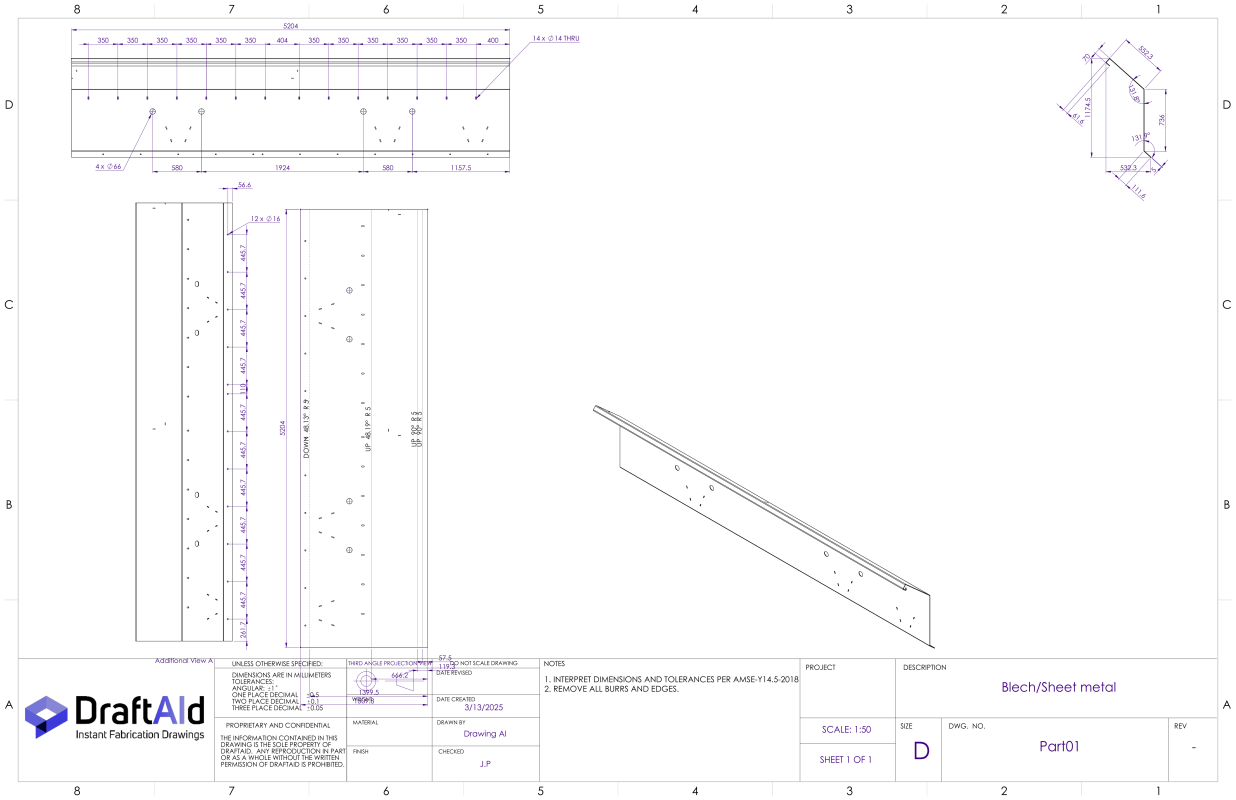

In [2]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img, 800)
img_comp = img.copy()

Image.fromarray(img_comp)

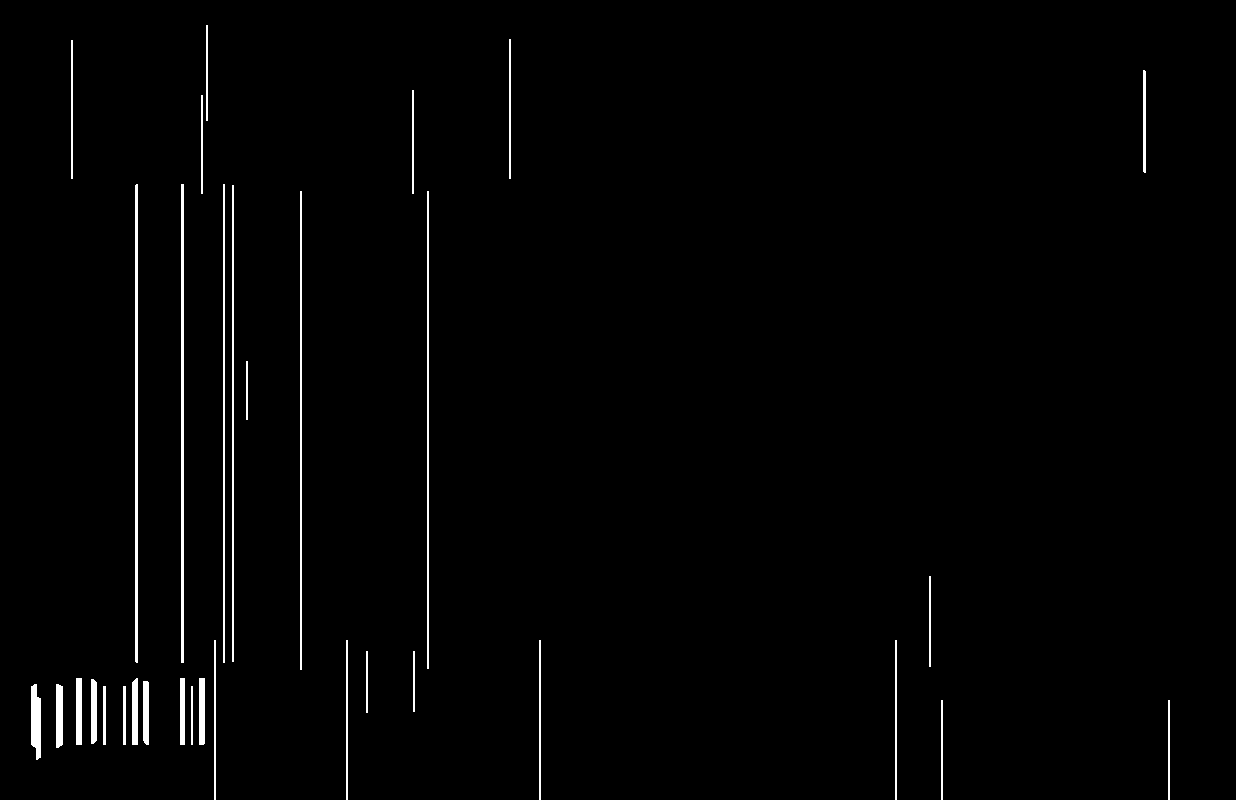

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_bin = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
image_height, image_width = img_bin.shape

SCALE = 40
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, image_height // SCALE))
vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
vertical_lines = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 40)))

Image.fromarray(vertical_lines)

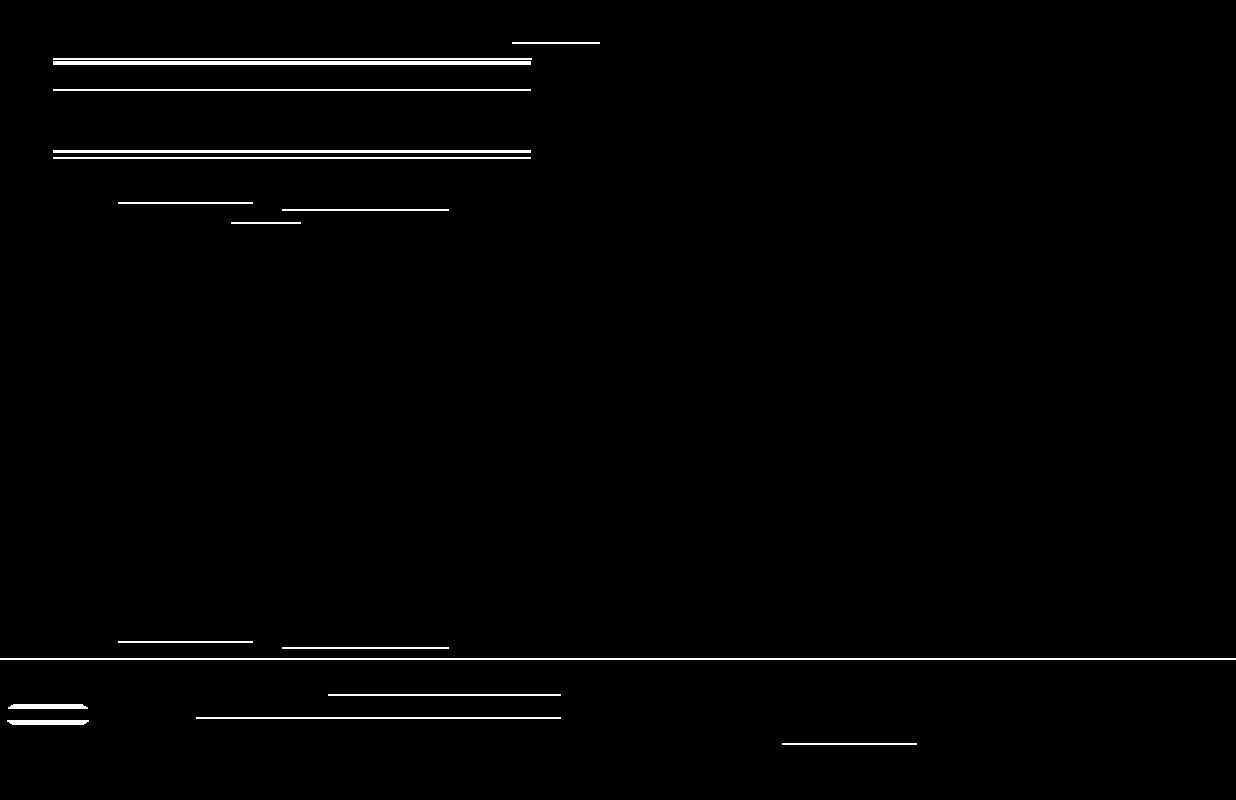

In [4]:
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (image_width // SCALE, 1))
horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
horizontal_lines = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 2)))

Image.fromarray(horizontal_lines)

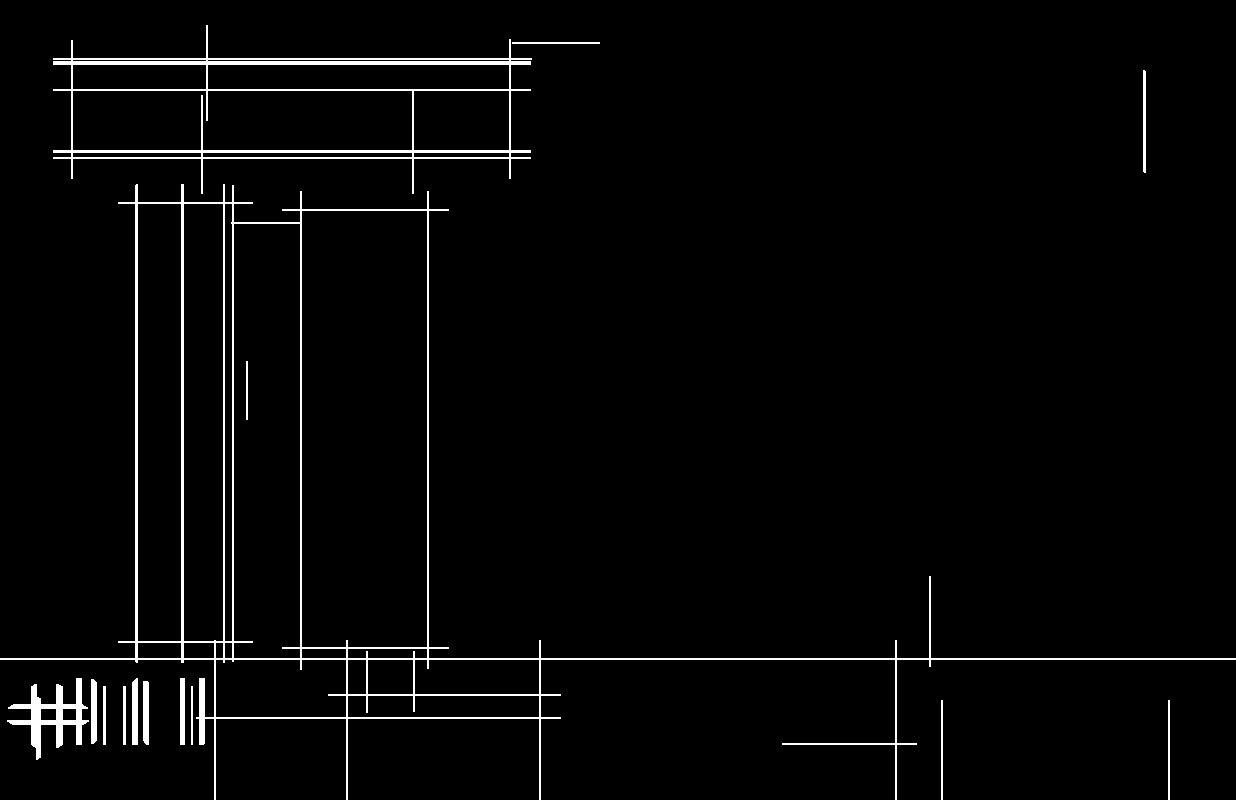

In [5]:
# merged_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
merged_lines = vertical_lines + horizontal_lines

Image.fromarray(merged_lines)

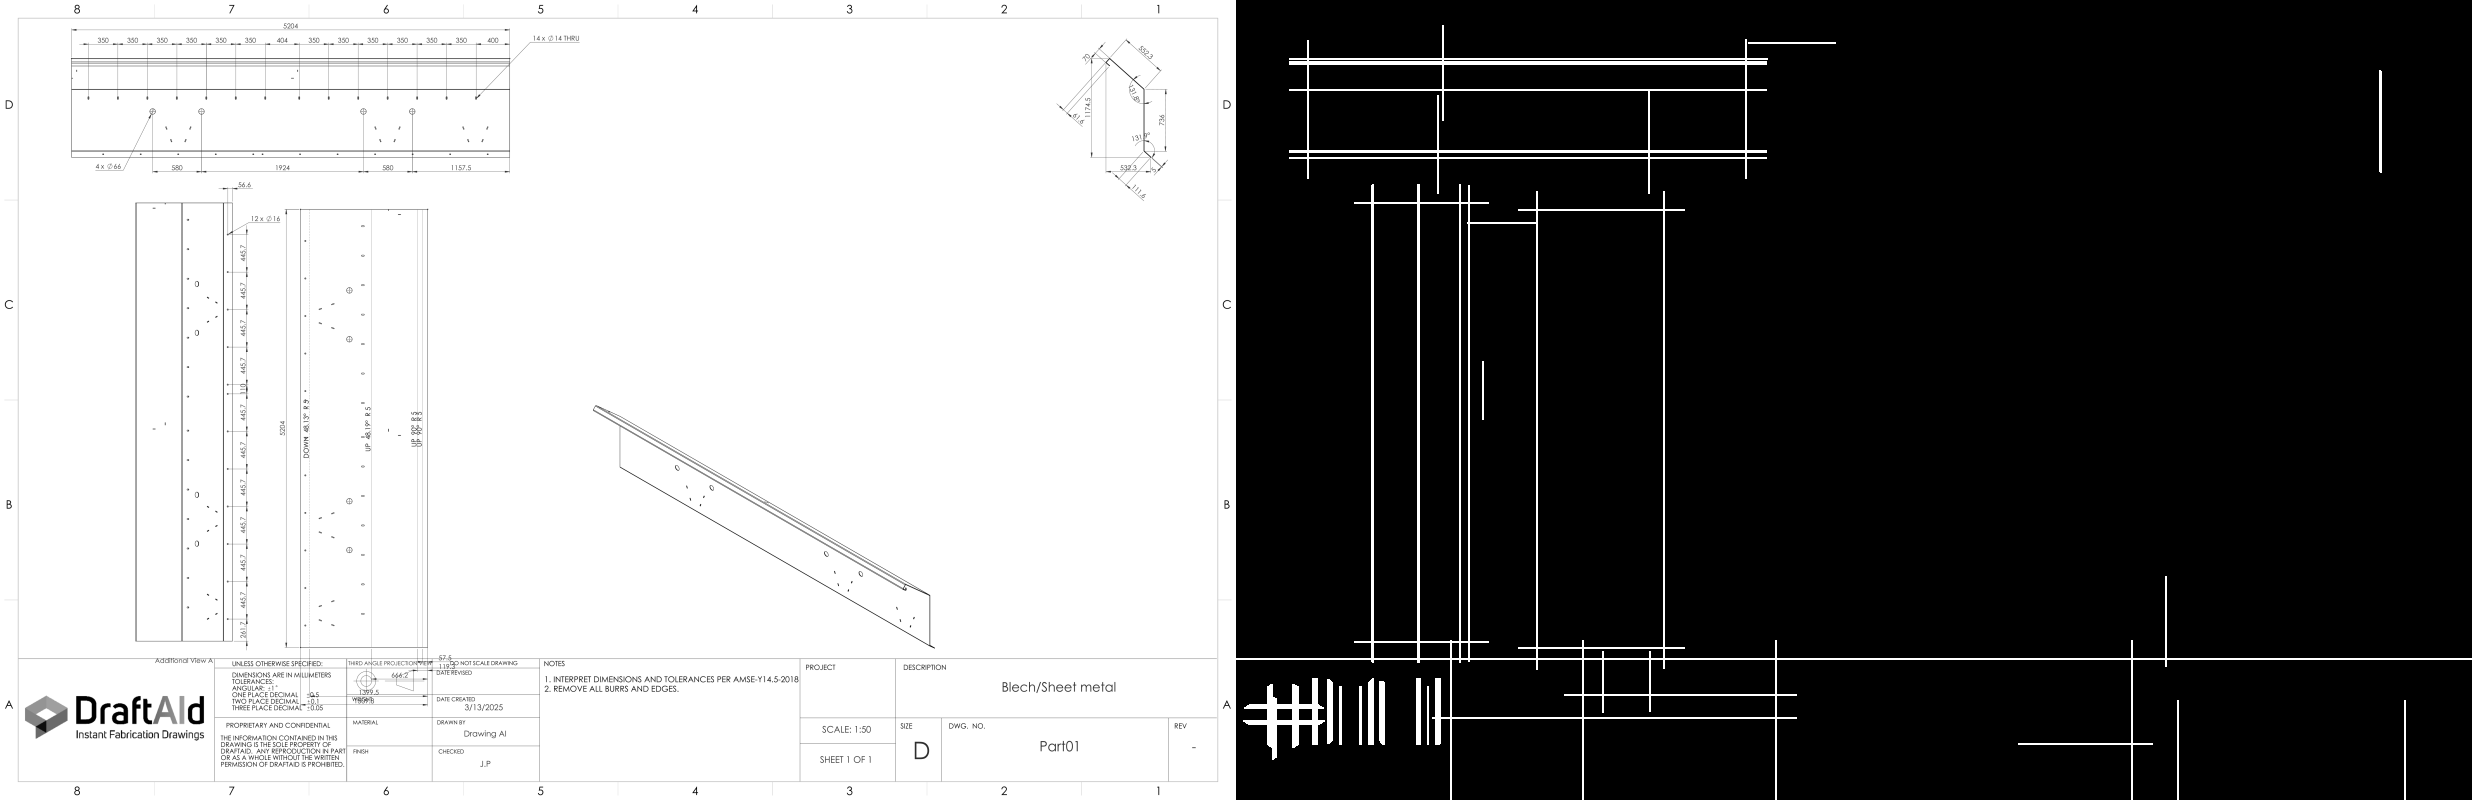

In [6]:
Image.fromarray(np.hstack((gray, merged_lines)))

14


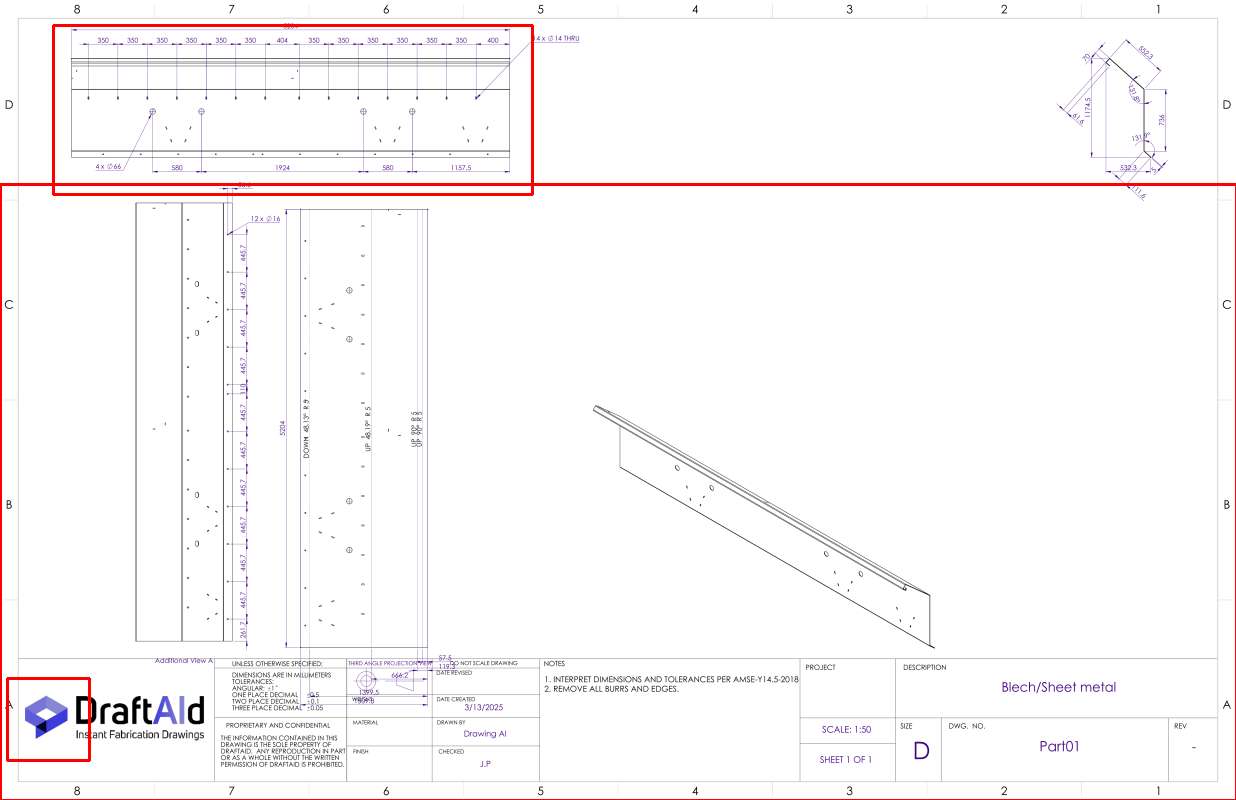

In [7]:
_, binary = cv2.threshold(merged_lines, 128, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
img_comp = img.copy()

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / float(h)
    area = w * h

    if area > 1000 and (0.5 < aspect_ratio < 10):
        cv2.rectangle(img_comp, (x, y), (x + w, y + h), (255, 0, 0), 2)

Image.fromarray(img_comp)

In [8]:
mask = merged_lines.copy()
contours, heirarchy = cv2.findContours(
    mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
)

MIN_TABLE_AREA = 1
contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
epsilons = [0.1 * p for p in perimeter_lengths]
approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

bounding_rects

[(1168, 700, 2, 100),
 (941, 700, 2, 100),
 (191, 686, 2, 59),
 (123, 686, 3, 59),
 (103, 686, 3, 59),
 (143, 681, 6, 64),
 (91, 679, 3, 65),
 (180, 678, 5, 67),
 (132, 678, 6, 67),
 (36, 678, 46, 82),
 (0, 658, 1236, 2),
 (1143, 70, 3, 103),
 (512, 42, 88, 2),
 (53, 58, 478, 101)]